# CHAPTER 4 word2vec 속도 개선

## 4-1 word2vec 개성 (1)

### 4-1-1 Embedding 계층

### 4-1-2 embedding 계층 구현

In [17]:
class Embedding:
    def __init__(self , W):
        self.params = [W]
        self.grads = [np.zeors_like(W)]
        self.idx = None

    def forward(self ,idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self , dout):
        dW, = self.grads
        dW[...] = 0
        dW[self.idx] = dout # 실은 나쁜 예
        return None



In [18]:
class Embedding:
    def __init__(self , W):
        self.params = [W]
        self.grads = [np.zeors_like(W)]
        self.idx = None

    def forward(self ,idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self , dout):
        dW, = self.grads
        dW[...] = 0
        
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]

        return None

## 4-2 word2vec 개선 (2)

### 4-2-1 은닉층 이후 계산의 문제점

### 4-2-2 다중 분류에서 이진 분류로

### 4-2-3 시그모이드 함수와 교차 엔트로피 오차

### 4-2-4 다중 분류에서 이진 분류로 (구현

In [32]:
import numpy as np

class EmbeddingDot:
    def __init__(self , W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self , h , idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h , axis = 1)

        self.cashe = (h , target_W)
        return out

    def backward(self ,dout):
        h, target_W = self.cashe
        dout = dout.reshape(dout.shape[0] , 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### 4-2-5 네거티브 샘플링

### 4-2-6 네거티브 샘플링의 샘플링 기법

In [33]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler=UnigramSampler(corpus , power , sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[2 3]
 [0 1]
 [3 4]]


### 4-2-7 네거티브 샘플링 구현

In [34]:
add = '/content/drive/MyDrive/AI/독학/밑시딥 2'
import sys
sys.path.append(add)

In [35]:
from negative_sampling_layer import UnigramSampler
from common.layers import *
from common.functions import *

In [43]:
class NegativeSamplingLoss:
    def __init__(self ,W  ,corpus , power = 0.75 , sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus , power , sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params , self.grads = [], []

        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self , h , target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h , target)
        correct_label = np.ones(batch_size , dtype = np.int32)
        loss = self.loss_layers[0].forward(score , correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size , dtype = np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[: , i]
            score = self.embed_dot_layers[1 + i].forward(h , negative_target)
            loss += self.loss_layers[1 + i].forward(score , negative_label)

        return loss

    def backward(self, dout = 1):
        dh = 0
        for l0 , l1 in zip(self.loss_layers , self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh


## 4-3 개선판 word2vec 학습

### 4-3-1 CBOW 모델 구현

In [51]:
add = '/content/drive/MyDrive/AI/독학/밑시딥 2'
import sys
sys.path.append(add)
import numpy as np
from common.layers import Embedding

class CBOW:
    def __init__(self, vocab_size , hidden_size  ,window_size , corpus):
        V ,H = vocab_size , hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V , H).astype('f')
        W_out = 0.01 * np.random.randn(V , H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)     # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out , corpus , power = 0.75 , sample_size = 5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params , self.grads = [] , []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self , contexts , target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[: , i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h , target)
        return loss

    def backward(self , dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


### 4-3-2 CBOW 모델 학습 코드

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 5[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 7[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 8[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 10[s] | 손실 3.80
| 에폭 1 |  반복 141 / 9295 | 시간 12[s] | 손실 3.65
| 에폭 1 |  반복 161 / 9295 | 시간 14[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 15[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 17[s] | 손실 3.24
| 에폭 1 |  반복 221 / 9295 | 시간 18[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 20[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 22[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 24[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 25[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 27[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 29[s] | 손실 2.85
| 에폭 1 |  반복 361 / 9295 | 시간 30[s] | 손실 2.80
| 에폭 1 |  반복 381 / 9295 | 시간 32[s] | 손실 2.79
| 에폭 1 |  반복 401 / 9295 | 시간 34[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 35[s] | 손실 2.76
| 에폭 1 |  반복 441 / 929

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

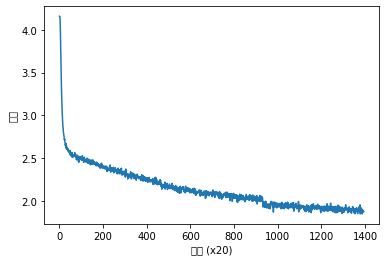

In [49]:
add = '/content/drive/MyDrive/AI/독학/밑시딥 2'
import sys
sys.path.append(add)
import numpy as np
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target , to_cpu , to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size  = 100
max_epoch = 3

# 데이터 일기
corpus , word_to_id , id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts , target = create_contexts_target(corpus , window_size)
if config.GPU:
    contexts , target = to_gpu(contexts) , to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size , hidden_size , window_size , corpus)
optimizer = Adam()
trainer = Trainer(model , optimizer)

# 학습 시작
trainer.fit(contexts , target , max_epoch , batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 지정
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file , 'wb') as f:
    pickle.dump(params , f , -1)

### 4-3-3 CBOW 모델 평가

In [50]:
import sys
sys.path.append(add)
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file , 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you' , 'year' , 'car' , 'toyota']
for query in querys:
    most_similar(query , word_to_id , id_to_word , word_vecs , top = 5)


[query] you
 we: 0.91162109375
 i: 0.8916015625
 somebody: 0.87353515625
 else: 0.8701171875
 why: 0.86669921875

[query] year
 month: 0.92919921875
 summer: 0.86962890625
 week: 0.8642578125
 spring: 0.86181640625
 forecast: 0.6416015625

[query] car
 truck: 0.81689453125
 supercomputer: 0.81494140625
 machine: 0.79345703125
 engine: 0.78369140625
 passion: 0.77685546875

[query] toyota
 occidental: 0.8330078125
 weyerhaeuser: 0.8330078125
 nec: 0.826171875
 coca-cola: 0.81396484375
 unocal: 0.81005859375


## 4-4 word2vec 남은 주제

### 4-4-1 word2vec을 사용한 애플리케이션의 예

### 4-4-2 단어 벡터 평가 방법

## 4-5 정리